In [1]:
### Importing all the neccessary packages ###
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal
from scipy.stats import circmean
from scipy import optimize
import xarray.ufuncs as xu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import seaborn as sns


In [2]:
### Allows us to use dask to speed up some calculations ###
from dask.distributed import Client
client = Client()


distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-5jog5ppl', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-c18rrf9i', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-qdgudc4g', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-n123882n', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-_cwbl0yo', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-4tgdttx6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-wor

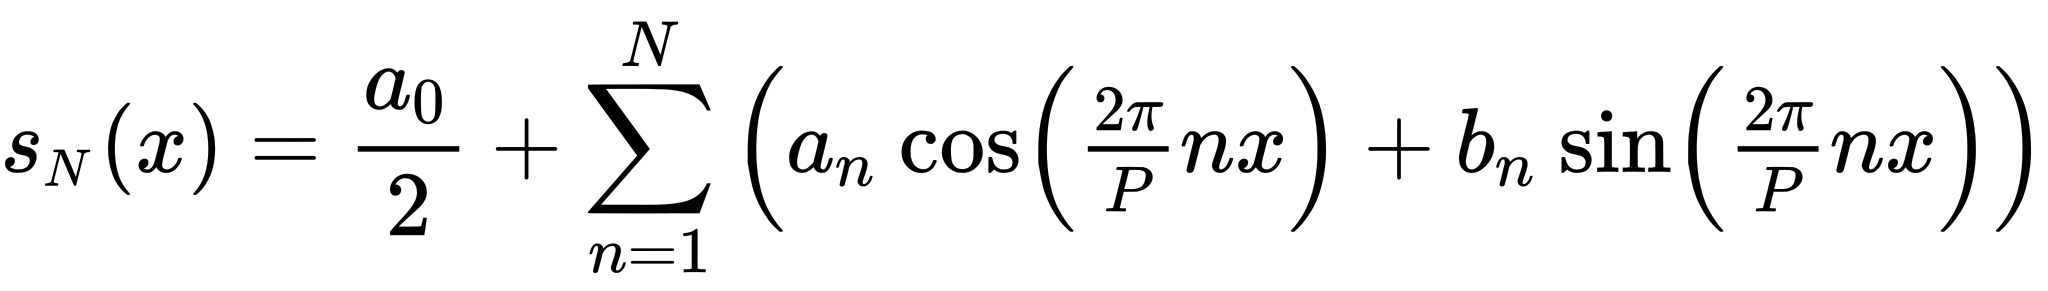

In [3]:
### This is the form of fourier series both matlab and python utilize ###

from IPython.display import SVG, display
SVG(url='https://wikimedia.org/api/rest_v1/media/math/render/svg/908d750bbbc3c640ef8103852f9843d283f06b65')

In [4]:

def curve(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5):
    output = (a0 +
    a1*np.cos(x/len(x)*2*np.pi) + b1*np.sin(x/len(x)*2*np.pi) + 
    a2*np.cos(x/len(x)*2*np.pi*2) + b2*np.sin(x/len(x)*2*np.pi*2)+ 
    a3*np.cos(x/len(x)*3*np.pi*2) + b3*np.sin(x/len(x)*3*np.pi*2)+
    a4*np.cos(x/len(x)*4*np.pi*2) + b4*np.sin(x/len(x)*4*np.pi*2)+
    a5*np.cos(x/len(x)*5*np.pi*2) + b5*np.sin(x/len(x)*5*np.pi*2))
    
    return output
    
def fit_curve(xdata, ydata):
    guess = [np.mean(ydata), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    params, params_covariance = optimize.curve_fit(curve, xdata, ydata, guess)
    return params, params_covariance

def fourier5(tseries):
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    params, _ = fit_curve(time,tseries)
    return np.argmin(curve(time,*params))
    
    
    

In [5]:
def curve_2harmonic(x, a0, a1, b1, a2, b2):
    output = (a0 +
    a1*np.cos(x/len(x)*2*np.pi) + b1*np.sin(x/len(x)*2*np.pi) + 
    a2*np.cos(x/len(x)*2*np.pi*2) + b2*np.sin(x/len(x)*2*np.pi*2))
    return output

def fit_curve2(xdata, ydata):
    guess = [np.mean(ydata), 0, 0, 0, 0]
    params, params_covariance = optimize.curve_fit(curve_2harmonic, xdata, ydata, guess)
    return params, params_covariance

def fourier2(tseries):
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    params, _ = fit_curve2(time,tseries)
    return curve_2harmonic(time,*params)
    
    


In [8]:
def seasonality(tseries):
    mtot = len(tseries)
    time=np.arange(1,mtot+1,1.)
    params, _ = fit_curve2(time,tseries)
    return (params[2]/params[1])

In [7]:
### Data Directory For Narwhal ###
data_dir = '/data/deluge/scratch/ERA5/2D/daily/precip/'

In [8]:
### Bombardi et al., 2019 has put the code on github under the MIT license, which allows us to utilize their code in any way we see fit. 
### We will of course credit Bombardi et al., 2019 in the eventual manuscript.

In [9]:
### Opening all of the ERA5 daily precipitation data. The 'time':-1 section loads the data such that each 'chunk' has the entire time series, but is only 100x100 lat, lon.
ds = xr.open_mfdataset(data_dir+'*.nc',parallel=True, chunks={'latitude': 25, 'longitude': 25, 'time': -1})


In [10]:
### subsetting the data so we grab only north america.
subset=ds.sel(latitude=slice(50,30), longitude=slice((360.0-120),(360.0-85.0)))


In [11]:
### Showing the advantage of using Dask to perform operations ###
### Time without dask:  319 seconds.  
### Time with dask: 155 seconds.


start = time.time()



ds_subset = subset.load()
end = time.time()
print(end - start)


116.95518827438354


In [12]:
ds_subset

<xarray.Dataset>
Dimensions:    (time: 25599, bnds: 2, longitude: 71, latitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01T15:00:00 ... 2020-02-01T11:00:00
  * longitude  (longitude) float32 240.0 240.5 241.0 241.5 ... 274.0 274.5 275.0
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 31.5 31.0 30.5 30.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1950-01-01T07:00:00 ... 2020-02-01...
    precip     (time, latitude, longitude) float32 0.002374 ... 5.178e-05
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 26 14:30:53 2021: cdo -b F32 daysum precip.195001.n...
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [13]:
### Changing data to mm and removing leap days ###
ds_subset['precip'].values = ds_subset['precip'].values*1000.0
precip = ds_subset['precip']
precip = precip.sel(time=~((precip.time.dt.month == 2) & (precip.time.dt.day == 29)))

### Calculating the mean precipitation for each grid point
annual_mean_precip = precip.mean(dim='time')

### Calculating the mean annual cycle ###
annual_precip_cycle= precip.groupby('time.dayofyear').mean(dim='time')

annual_precip_cycle_var = precip.groupby('time.dayofyear').std(dim='time')

### Create Daily precip from hourly ###
##daily_precip = precip.resample(time='1D').sum()

### Create The annual daily precip anomalies ###
annual_means = precip.groupby('time.year').mean(dim='time')

anomalies = precip.groupby('time.year') - annual_means
#anomalies = anomalies_withleap.sel(time=~((anomalies_withleap.time.dt.month == 2) & (anomalies_withleap.time.dt.day == 29)))

climDailyMeanAnomaly = annual_precip_cycle - annual_mean_precip

(array([7.03000e+02, 6.28050e+04, 5.51374e+05, 3.63959e+05, 7.36080e+04,
        1.13190e+04, 1.41100e+03, 2.02000e+02, 4.00000e+01, 5.00000e+00]),
 array([-3.7943072 , -2.5155964 , -1.2368857 ,  0.04182515,  1.3205359 ,
         2.5992467 ,  3.8779576 ,  5.156668  ,  6.435379  ,  7.71409   ,
         8.992801  ], dtype=float32),
 <BarContainer object of 10 artists>)

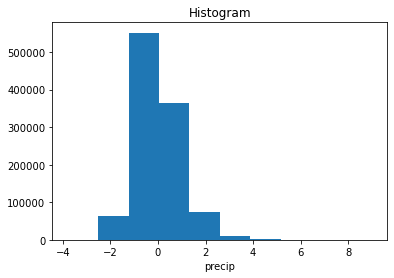

In [ ]:
harmonic_cycle = xr.apply_ufunc(
    fourier5,
    annual_precip_cycle.load(),
    input_core_dims=[["dayofyear"]],
    exclude_dims=set(["dayofyear"]),
    output_core_dims=[["dayofyear"]],
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)
harmonic_cycle.to_netcdf('harmonic_cycle.nc')

In [47]:
seasonality_ratio = xr.apply_ufunc(
    computeRelEntr,
    harmonic_cycle,
    input_core_dims=[["dayofyear"]],
    exclude_dims=set(["dayofyear"]),
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)

In [49]:
seasonality_ratio2 = xr.apply_ufunc(
    seasonality,
    annual_precip_cycle,
    input_core_dims=[["dayofyear"]],
    exclude_dims=set(["dayofyear"]),
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)

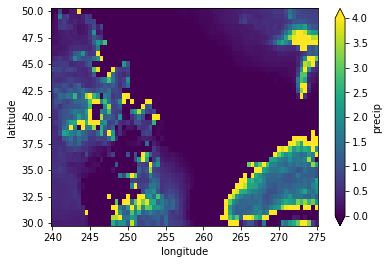

In [52]:
seasonality_ratio2.plot(vmin=0,vmax=4)

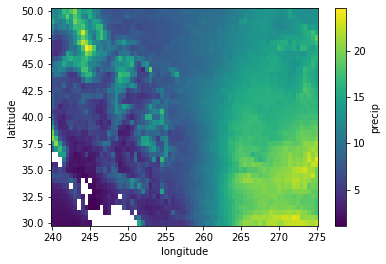

In [48]:
seasonality_ratio.plot()

In [22]:
harmonic_cycle = xr.open_dataarray('harmonic_cycle.nc')

In [23]:
### Code acquired from 

In [24]:
lat = 45
lon = 271

index = annual_precip_cycle.sel(latitude=lat,longitude=lon).dayofyear.values

vals = annual_precip_cycle.sel(latitude=lat,longitude=lon).values


harmonic_cycle.sel(latitude=lat, longitude=lon).plot()

In [39]:
from scipy.special import rel_entr

In [57]:
np.mean(harmonic_cycle.sel(latitude=lat, longitude=lon).values)

0.24502956994569977

In [45]:
def computeRelEntr(harmonic_cycle):
    p = harmonic_cycle
    meanHC = np.mean(p)
    q = np.zeros(len(harmonic_cycle))
    q[:] = meanHC/(len(harmonic_cycle))
    
    return np.sum(rel_entr(p,q))/len(harmonic_cycle)

In [56]:
computeRelEntr(harmonic_cycle.sel(latitude=lat, longitude=lon).values)

inf

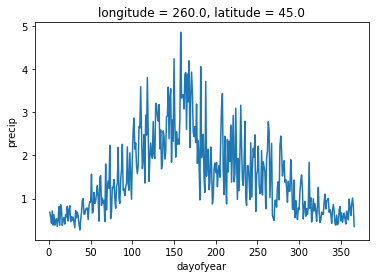

In [30]:
annual_precip_cycle.sel(latitude=lat,longitude=lon).plot()

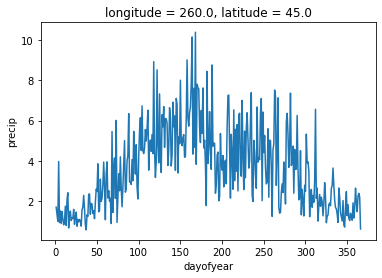

In [31]:
annual_precip_cycle_var.sel(latitude=lat,longitude=lon).plot()

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


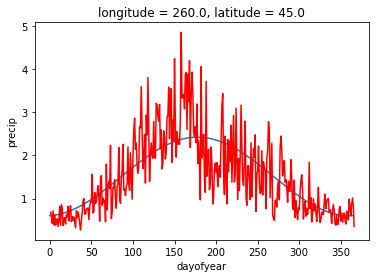

In [246]:
plt.plot(Harmonics(vals))
annual_precip_cycle.sel(latitude=lat,longitude=lon).plot(color='red')

In [32]:
fourier5(vals)

356

In [33]:
np.argmin(fourier2(vals))

14

In [34]:
fourier1(vals)

352

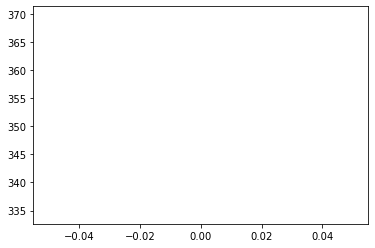

In [90]:
plt.plot(fourier1(vals))

In [248]:
cumsumClimDailyMeanAnomaly = climDailyMeanAnomaly.sel(latitude=lat,longitude=lon).cumsum()


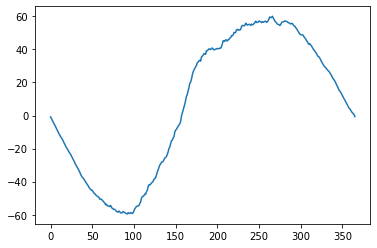

In [249]:
plt.plot(cumsumClimDailyMeanAnomaly)

In [232]:
signal.find_peaks(-cumsumClimDailyMeanAnomaly.rolling(dayofyear=30).mean())

(array([112, 287, 290]), {})

In [233]:
signal.find_peaks(cumsumClimDailyMeanAnomaly.rolling(dayofyear=30).mean())

(array([283, 289, 293]), {})

In [234]:
mean = annual_mean_precip.sel(latitude=lat, longitude=lon).values

In [235]:
mean_filter = np.zeros(len(harmonic_cycle.sel(latitude=lat, longitude=lon)))
mean_filter[:] = mean

In [236]:
peaks = signal.find_peaks(harmonic_cycle.sel(latitude=lat, longitude=lon), height = mean_filter)[0]

In [237]:
valleys = signal.find_peaks(-harmonic_cycle.sel(latitude=lat, longitude=lon),height = -mean_filter)[0]

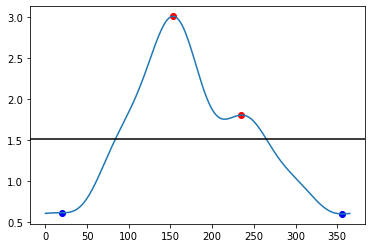

In [241]:
seasonVals = harmonic_cycle.sel(latitude=lat, longitude=lon).values

plt.plot(seasonVals)
plt.scatter(peaks,seasonVals[peaks], color='red')
plt.scatter(valleys,seasonVals[valleys],color='blue')
plt.axhline(annual_mean_precip.sel(latitude=lat, longitude=lon).values, color='black')

In [35]:
newDataDim = len(annual_mean_precip.latitude)*len(annual_mean_precip.longitude)
new_data = np.reshape(harmonic_cycle.values, (newDataDim,366))

In [36]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
newDataNormalized = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(new_data).squeeze()

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [37]:
from tslearn.clustering import TimeSeriesKMeans
sdtw_km = TimeSeriesKMeans(n_clusters=4,
                           metric="dtw",
                           verbose=1, n_jobs=16)
#y_pred = sdtw_km.fit_predict(X_train)


In [38]:
testing = sdtw_km.fit(newDataNormalized)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 2418 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 2911 out of 2911 | elapsed:    2.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.3s
[Parallel(n_job

25.367 --> 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 2418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 3168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 4018 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 4968 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 6018 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 7168 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 8418 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 9768 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 11218 tasks 

7.508 --> 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 2418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 3168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 4018 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 4968 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 6018 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 7168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 8418 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 9768 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 11218 tasks 

6.876 --> 

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [32]:
from sklearn.cluster import KMeans
new_data = np.reshape(harmonic_cycle.values, (newDataDim,366))
estimator = KMeans(n_clusters = 20, algorithm='full', tol = .001, n_init=50 )
cluster_fits = estimator.fit(new_data)

In [41]:
testing.labels_

array([4, 4, 2, ..., 1, 1, 1])

In [50]:
clusters = np.reshape(testing.labels_,(len(annual_mean_precip.latitude),len(annual_mean_precip.longitude)))

In [51]:
cluster_ds = xr.zeros_like(annual_mean_precip)

In [52]:
cluster_ds.values = clusters

In [53]:
cluster_ds = cluster_ds.rename('clusters')

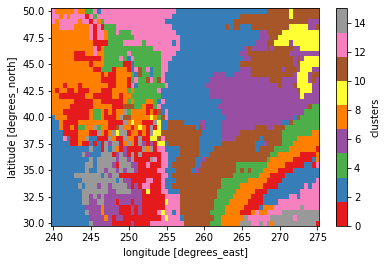

In [55]:
cluster_ds.plot(cmap='Set1')

In [54]:
cluster_ds.to_netcdf('cluster_ds.nc')

In [23]:
cluster_ds = xr.open_dataarray('cluster_ds.nc')

In [ ]:
annual_precip_cycle

In [30]:
"""
Funtion that calculates the Fourier coefficients and the explained variance of the Nth
first harmonics of a time series
Input:
   tseries: input time series
   nmodes : number of harmonics to retain (N)
   coefa  : Array with N (or 'nmodes') elements
   coefb  : Array with N (or 'nmodes') elements
   hvar   : Array with N (or 'nmodes') elements
   missval: Falg value for missing data
Output:
   coefa: Array of A coefficients of the Nth first harmonics
   coefb: Array of B coefficients of the Nth first harmonics
   hvar : Array of explained variance of the Nth first harmonics
"""

### This function returns the minimum of the 1st harmonic which will serve as the start date for onset calculation.

def Harmonics(tseries, nmodes=5,missval=np.nan):
    tot = 366 ### Dealing with only 1 year of data here
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    newdim=len(tseries)  # removing missing data
    harmonic1 =np.zeros((tot))
    tdata=tseries
    svar=np.sum((tdata[:]-np.mean(tdata))**2)//(newdim-1)
    nm=nmodes
    if 2*nm > newdim:
        nm=newdim/2
    coefa=np.zeros((nm))
    coefb=np.zeros((nm))
    hvar=np.zeros((nm))
    harmonic1[:] = np.mean(tseries)
    for tt in range(0,nm):
        Ak=np.sum(tdata[:]*xu.cos(2.*np.pi*(tt+1)*time[:]/float(newdim)))
        Bk=np.sum(tdata[:]*xu.sin(2.*np.pi*(tt+1)*time[:]/float(newdim)))
        coefa[tt]=Ak*2./float(newdim)
        coefb[tt]=Bk*2./float(newdim)
        hvar[tt]=newdim*(coefa[tt]**2+coefb[tt]**2)/(2.*(newdim-1)*svar)
        harmonic1=harmonic1+coefa[tt]*np.cos(2.*np.pi*time[:]/float(tot))+coefb[tt]*np.sin(2.*np.pi*time[:]/float(tot))
        
    # if hvar[1] >= hvar[0]:
    #     return np.nan
    # elif hvar[2] >= hvar[0]:
    #     return np.nan
    # else:
    return harmonic1

In [250]:
### Use dask to run the Harmonics finction over the data ### 
### Slightly faster than a loop but still slow ###
start_wet = xr.apply_ufunc(
fourier1,
annual_precip_cycle.load(),
input_core_dims=[["dayofyear"]],
exclude_dims=set(["dayofyear"]),
vectorize=True,
)


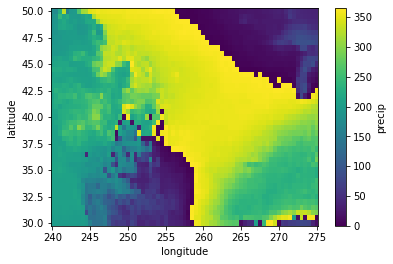

In [251]:
start_wet.plot()

In [60]:
array_jday = anomalies.time.dt.dayofyear
input_data = anomalies.assign_coords(jday=("time",array_jday.data))

In [61]:
start_wet = harmonic_cycle.argmin(dim='dayofyear')

In [ ]:
start_wet.to_netcdf('algorithm_start.nc')

In [ ]:
### Used for testing individual areas ###
data = input_data.isel(latitude=45, longitude=100).values
data_time = input_data.isel(latitude=45, longitude=100).time.values
data_jday = input_data.isel(latitude=45, longitude=100).jday.values

start_test = start_wet.isel(latitude=45, longitude=100).values

In [ ]:

#========================================================================
#  Subroutine that calculates the beginning date of the rainy season
# for a time series of precipitation
# nyrs   --> integer for the number of years in the input dataset
# tot    --> total number of points for one year of data (365)
# mtot   --> total number of points in the whole precipitation dataset
# jday   --> an array of Julian days
# day    --> an array of days
# month  --> an array of months
# year   --> an array of years
# jstart --> Julian day of the climatological date when the calculation
#            should start
# precip --> a time series of precipitation anomalies (against mean annual daily)
# npass  --> integer for the number of "passes" for the smoothing of the
#            time series of accumulated precipitation anomalies
#========================================================================#def rainyseason_onset(nyrs,ytot,jday,day,month,year,jstart,precip,sjday,sday,smonth,syear,curve):
#def rainyseason_onset(anomaly_ds,start_wet):
#
### From the apply_ufunc for testing ###
data = input_data.isel(latitude=45, longitude=100).values
data_time = input_data.isel(latitude=45, longitude=100).time.values
data_jday = input_data.isel(latitude=45, longitude=100).jday.values
start_test = start_wet.isel(latitude=45, longitude=100).values




In [ ]:
def onset_dunning(data, data_time, start_test):
    

In [62]:
def onset_bombardi(data, data_time, start_test):
    #print(f"data: {data.shape} | time: {data_time.shape} | start_test: {start_test.shape}")
    ### Precalculations ###
    sseries=np.zeros((int(366/2)))
    mtot= len(data)
    yt=-1
    data_time = pd.DatetimeIndex(data_time)
    start_list = np.where(data_time.dayofyear == start_test)[0]
    #print(start_test)
    nyrs = len(np.unique(data_time.year))
    ytot=365
    ### Data Structures to hold results ###
    sjday=np.empty((nyrs))
    sjday[:] = np.nan
    sdate=np.empty((nyrs),dtype='datetime64[D]')
    sdate[:] = 'nat'
    #smonth=np.zeros((nyrs))
    #syear=np.zeros((nyrs))
    ### Run through entire time series for one grid point ###
    for start in start_list:
        #print(start)
        #    for tt in range(0,mtot-5): # -5 to avoid calcualtion with short time series for last year
        #------------------------------------------------------------------------
        # Starting the calculation of accumulated anomalies in the rainy season
        #------------------------------------------------------------------------                 !
        #        if jday[tt] == jstart:
        if start < (mtot):         # -5 to avoid calcualtion with short time series for last year
            yt=yt+1
            beg= start
            end = beg+int(365/2)
            if end <= mtot-1:  # it is not the last year
                end2=int(ytot/2)
            if end > mtot-1:
                end=mtot-1
                end2=end-beg
            sseries[:]=0
            sseries[0:end2]=np.cumsum(data[beg:beg+end2])
            #curve[yt,:]=sseries[:]
            #-------------------------------------------------------------------------
            # Calculating onset and demise of the rainy season
            #-------------------------------------------------------------------------
            beg=0
            try:
                ons=np.where(sseries[0:end2] == sseries[0:end2].min())
            except ValueError:
                pass
                #print(beg)
            if len(ons[0]) > 0:
                
                beg=ons[0][0]+start+1
                #print(beg)
            if beg > 0 and beg < end:

                sjday[yt]= data_time[beg].dayofyear
                sdate[yt]= data_time[beg]
                #smonth[yt]= data_time[beg].month
                #syear[yt]= data_time[beg].day
    return sjday





#========================================================================
#                             End of subroutine
#========================================================================

In [63]:
def demise_calculation(data, data_time, start_test):
    ### Reverse Date for Demise Calculation
    data = data[::-1]
    data_time = data_time[::-1]
    ### Precalculations ###
    sseries=np.zeros((int(366/2)))
    mtot= len(data)
    yt=-1
    data_time = pd.DatetimeIndex(data_time)
    start_list = np.where(data_time.dayofyear == start_test)[0]
    #print(start_test)
    nyrs = len(np.unique(data_time.year))
    ytot=365
    ### Data Structures to hold results ###
    sjday=np.empty((nyrs))
    sjday[:] = np.nan
    sdate=np.empty((nyrs),dtype='datetime64[D]')
    sdate[:] = 'nat'
    #smonth=np.zeros((nyrs))
    #syear=np.zeros((nyrs))
    ### Run through entire time series for one grid point ###
    for start in start_list:
        #print(start)
        #    for tt in range(0,mtot-5): # -5 to avoid calcualtion with short time series for last year
        #------------------------------------------------------------------------
        # Starting the calculation of accumulated anomalies in the rainy season
        #------------------------------------------------------------------------                 !
        #        if jday[tt] == jstart:
        if start < (mtot):         # -5 to avoid calcualtion with short time series for last year
            yt=yt+1
            beg= start
            end = beg+int(365/2)
            if end <= mtot-1:  # it is not the last year
                end2=int(ytot/2)
            if end > mtot-1:
                end=mtot-1
                end2=end-beg
            sseries[:]=0
            sseries[0:end2]=np.cumsum(data[beg:beg+end2])
            #curve[yt,:]=sseries[:]
            #-------------------------------------------------------------------------
            # Calculating onset and demise of the rainy season
            #-------------------------------------------------------------------------
            beg=0
            try:
                ons=np.where(sseries[0:end2] == sseries[0:end2].min())
            except ValueError:
                #print(beg)
                pass
            if len(ons[0]) > 0:
                beg=ons[0][0]+start+1
                #print(beg)
            if beg > 0 and beg < end:

                sjday[yt]= data_time[beg].dayofyear
                sdate[yt]= data_time[beg]
                #smonth[yt]= data_time[beg].month
                #syear[yt]= data_time[beg].day
    return sjday[::-1]






In [65]:
### 500 seconds ###

### 423 without Dask... Need more optimization... ###
start = time.time()
"the code you want to test stays here"




demise_data = xr.apply_ufunc(
    demise_calculation,
    input_data,
    input_data.time,
    start_wet,
    input_core_dims=[["time"],["time"],[]],
    exclude_dims=set(["time"]),
    output_core_dims=[["year"]],
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)
end = time.time()
print(end - start)

28.939082622528076


In [64]:
### 500 Seconds ###
start = time.time()
"the code you want to test stays here"




onset_data = xr.apply_ufunc(
    onset_calculation,
    input_data,
    input_data.time,
    start_wet,
    input_core_dims=[["time"],["time"],[]],
    exclude_dims=set(["time"]),
    output_core_dims=[["year"]],
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)
end = time.time()
print(end - start)

29.81477999687195


In [88]:
onset_data.name = 'onset'
demise_data.name = 'demise'
onset_data.coords['year'] = pd.date_range("1950", periods=71, freq='YS')
demise_data.coords['year'] = pd.date_range("1950", periods=71, freq='YS')

In [89]:
test_onset = xr.merge([onset_data,demise_data])

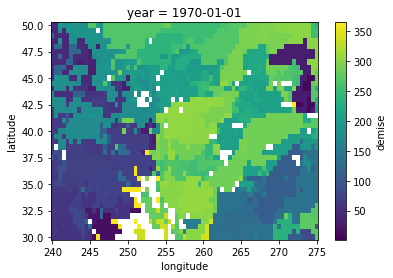

In [100]:
test_onset.sel(year='1970-01-01')['demise'].plot()

In [97]:
subset.sel(time='1950')

<xarray.Dataset>
Dimensions:    (time: 365, bnds: 2, longitude: 71, latitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01T15:00:00 ... 1950-12-31T11:00:00
  * longitude  (longitude) float32 240.0 240.5 241.0 241.5 ... 274.0 274.5 275.0
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 31.5 31.0 30.5 30.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1950-01-01T07:00:00 ... 1950-12-31...
    precip     (time, latitude, longitude) float32 2.374 1.813 ... 8.327e-14
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 26 14:30:53 2021: cdo -b F32 daysum precip.195001.n...
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [107]:
pd.Timedelta(test_onset['onset'].sel(year='1970-01-01').ravel(),unit='days')

AttributeError: 'DataArray' object has no attribute 'ravel'

In [102]:
pd.Timedelta(200, unit='days')

Timedelta('200 days 00:00:00')

In [93]:
for year in test_onset.year.values:
    onset_date = year + test_onset['onset'].sel(year=year)
    subset

1950-01-01T00:00:00.000000000
1951-01-01T00:00:00.000000000
1952-01-01T00:00:00.000000000
1953-01-01T00:00:00.000000000
1954-01-01T00:00:00.000000000
1955-01-01T00:00:00.000000000
1956-01-01T00:00:00.000000000
1957-01-01T00:00:00.000000000
1958-01-01T00:00:00.000000000
1959-01-01T00:00:00.000000000
1960-01-01T00:00:00.000000000
1961-01-01T00:00:00.000000000
1962-01-01T00:00:00.000000000
1963-01-01T00:00:00.000000000
1964-01-01T00:00:00.000000000
1965-01-01T00:00:00.000000000
1966-01-01T00:00:00.000000000
1967-01-01T00:00:00.000000000
1968-01-01T00:00:00.000000000
1969-01-01T00:00:00.000000000
1970-01-01T00:00:00.000000000
1971-01-01T00:00:00.000000000
1972-01-01T00:00:00.000000000
1973-01-01T00:00:00.000000000
1974-01-01T00:00:00.000000000
1975-01-01T00:00:00.000000000
1976-01-01T00:00:00.000000000
1977-01-01T00:00:00.000000000
1978-01-01T00:00:00.000000000
1979-01-01T00:00:00.000000000
1980-01-01T00:00:00.000000000
1981-01-01T00:00:00.000000000
1982-01-01T00:00:00.000000000
1983-01-01

In [74]:
pd.date_range("1979", periods=4, freq='YS')

DatetimeIndex(['1979-01-01', '1980-01-01', '1981-01-01', '1982-01-01'], dtype='datetime64[ns]', freq='AS-JAN')

In [ ]:
onset = onset_data.to_dataset(name='onset_date').apply(lambda x: np.ceil(x/5.0))

In [ ]:
onset.coords['year'] = np.unique(ds.time.dt.year)

In [ ]:
onset

In [ ]:
demise = demise_data.to_dataset(name='demise_date').apply(lambda x: np.ceil(x/5.0))

In [ ]:
demise.coords['year'] = np.unique(ds.time.dt.year)

In [ ]:
circmean(demise['demise_date'].isel(latitude=100, longitude=100).values,nan_policy='omit',high=365)

In [ ]:
vals = demise['demise_date'].isel(latitude=100, longitude=100)

In [ ]:
circmed(vals)

In [ ]:
def circmed(values):
    tmpx=np.cos(values[:]*np.pi/183.)
    tmpy=np.sin(values[:]*np.pi/183.)
    med=np.arctan2(np.nanmedian(tmpy),np.nanmedian(tmpx))*183./np.pi
    return med

In [ ]:
test_mean = xr.apply_ufunc(
    circmed,
    demise['demise_date'],
    input_core_dims=[["year"]],
    exclude_dims=set(["year"]),
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)

In [ ]:
test_mean.plot()

In [ ]:
demise.to_netcdf('wetseason.demise.era5.nc')

In [ ]:
onset.to_netcdf('wetseason.onset.era5.nc')

In [ ]:
(test_mean - demise['demise_date'].mean(dim='year')).plot()

In [ ]:
## TODO: Need to reverse the output array ###

demise['demise_date'].mean(dim='year').plot(figsize=(13,8))

In [ ]:
test6['onset_date'].mean(dim='data_jday').plot(figsize=(13,8))

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


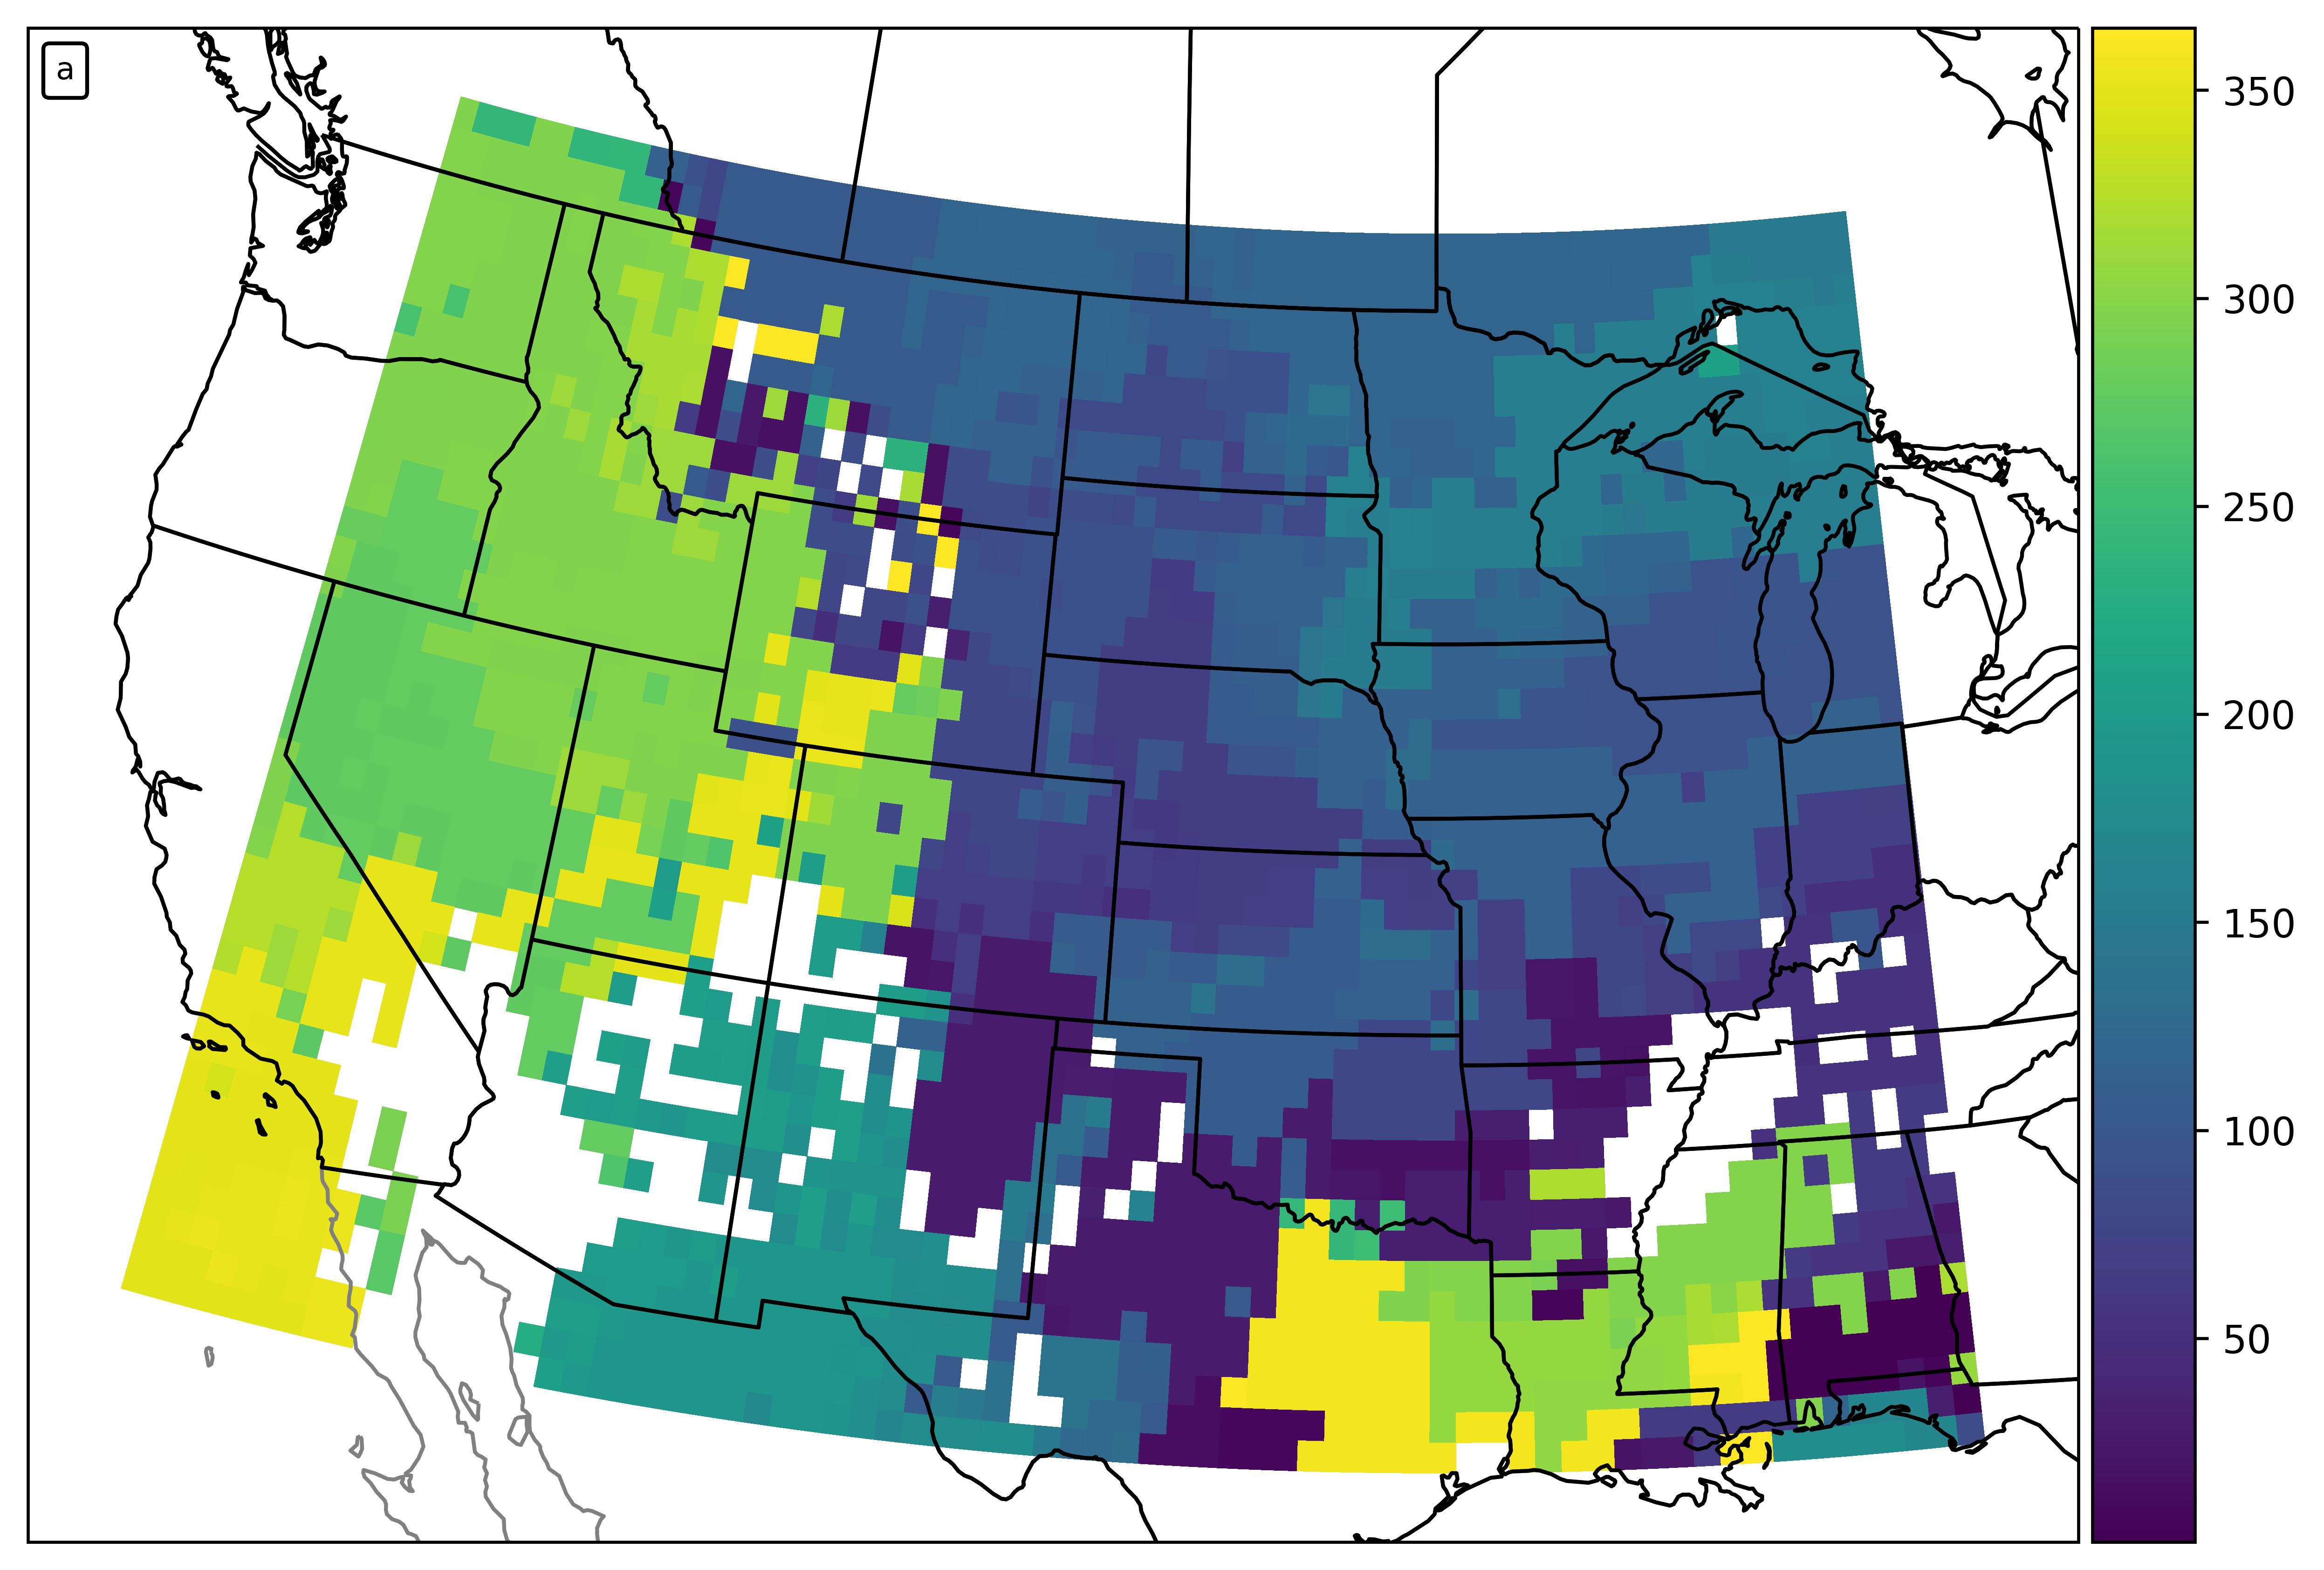

In [69]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
#cmap = mpl.cm.RdBu_r


f, ax1 = plt.subplots(1, 1, figsize=(10, 13), dpi=600, subplot_kw={'projection': map_proj})
p = onset_data.isel(year=60).plot.pcolormesh(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='viridis')


### Setting 1st plot parameters ###
ax1.coastlines(color='grey')
ax1.add_feature(cartopy.feature.BORDERS, color='black')
ax1.add_feature(cfeature.STATES, edgecolor='black')
#ax1.set_xticks(np.arange(-180,181, 40))
#ax1.set_yticks(np.arange(-90,91,15))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
at = AnchoredText("a",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
plt.colorbar(p, cax=cax)

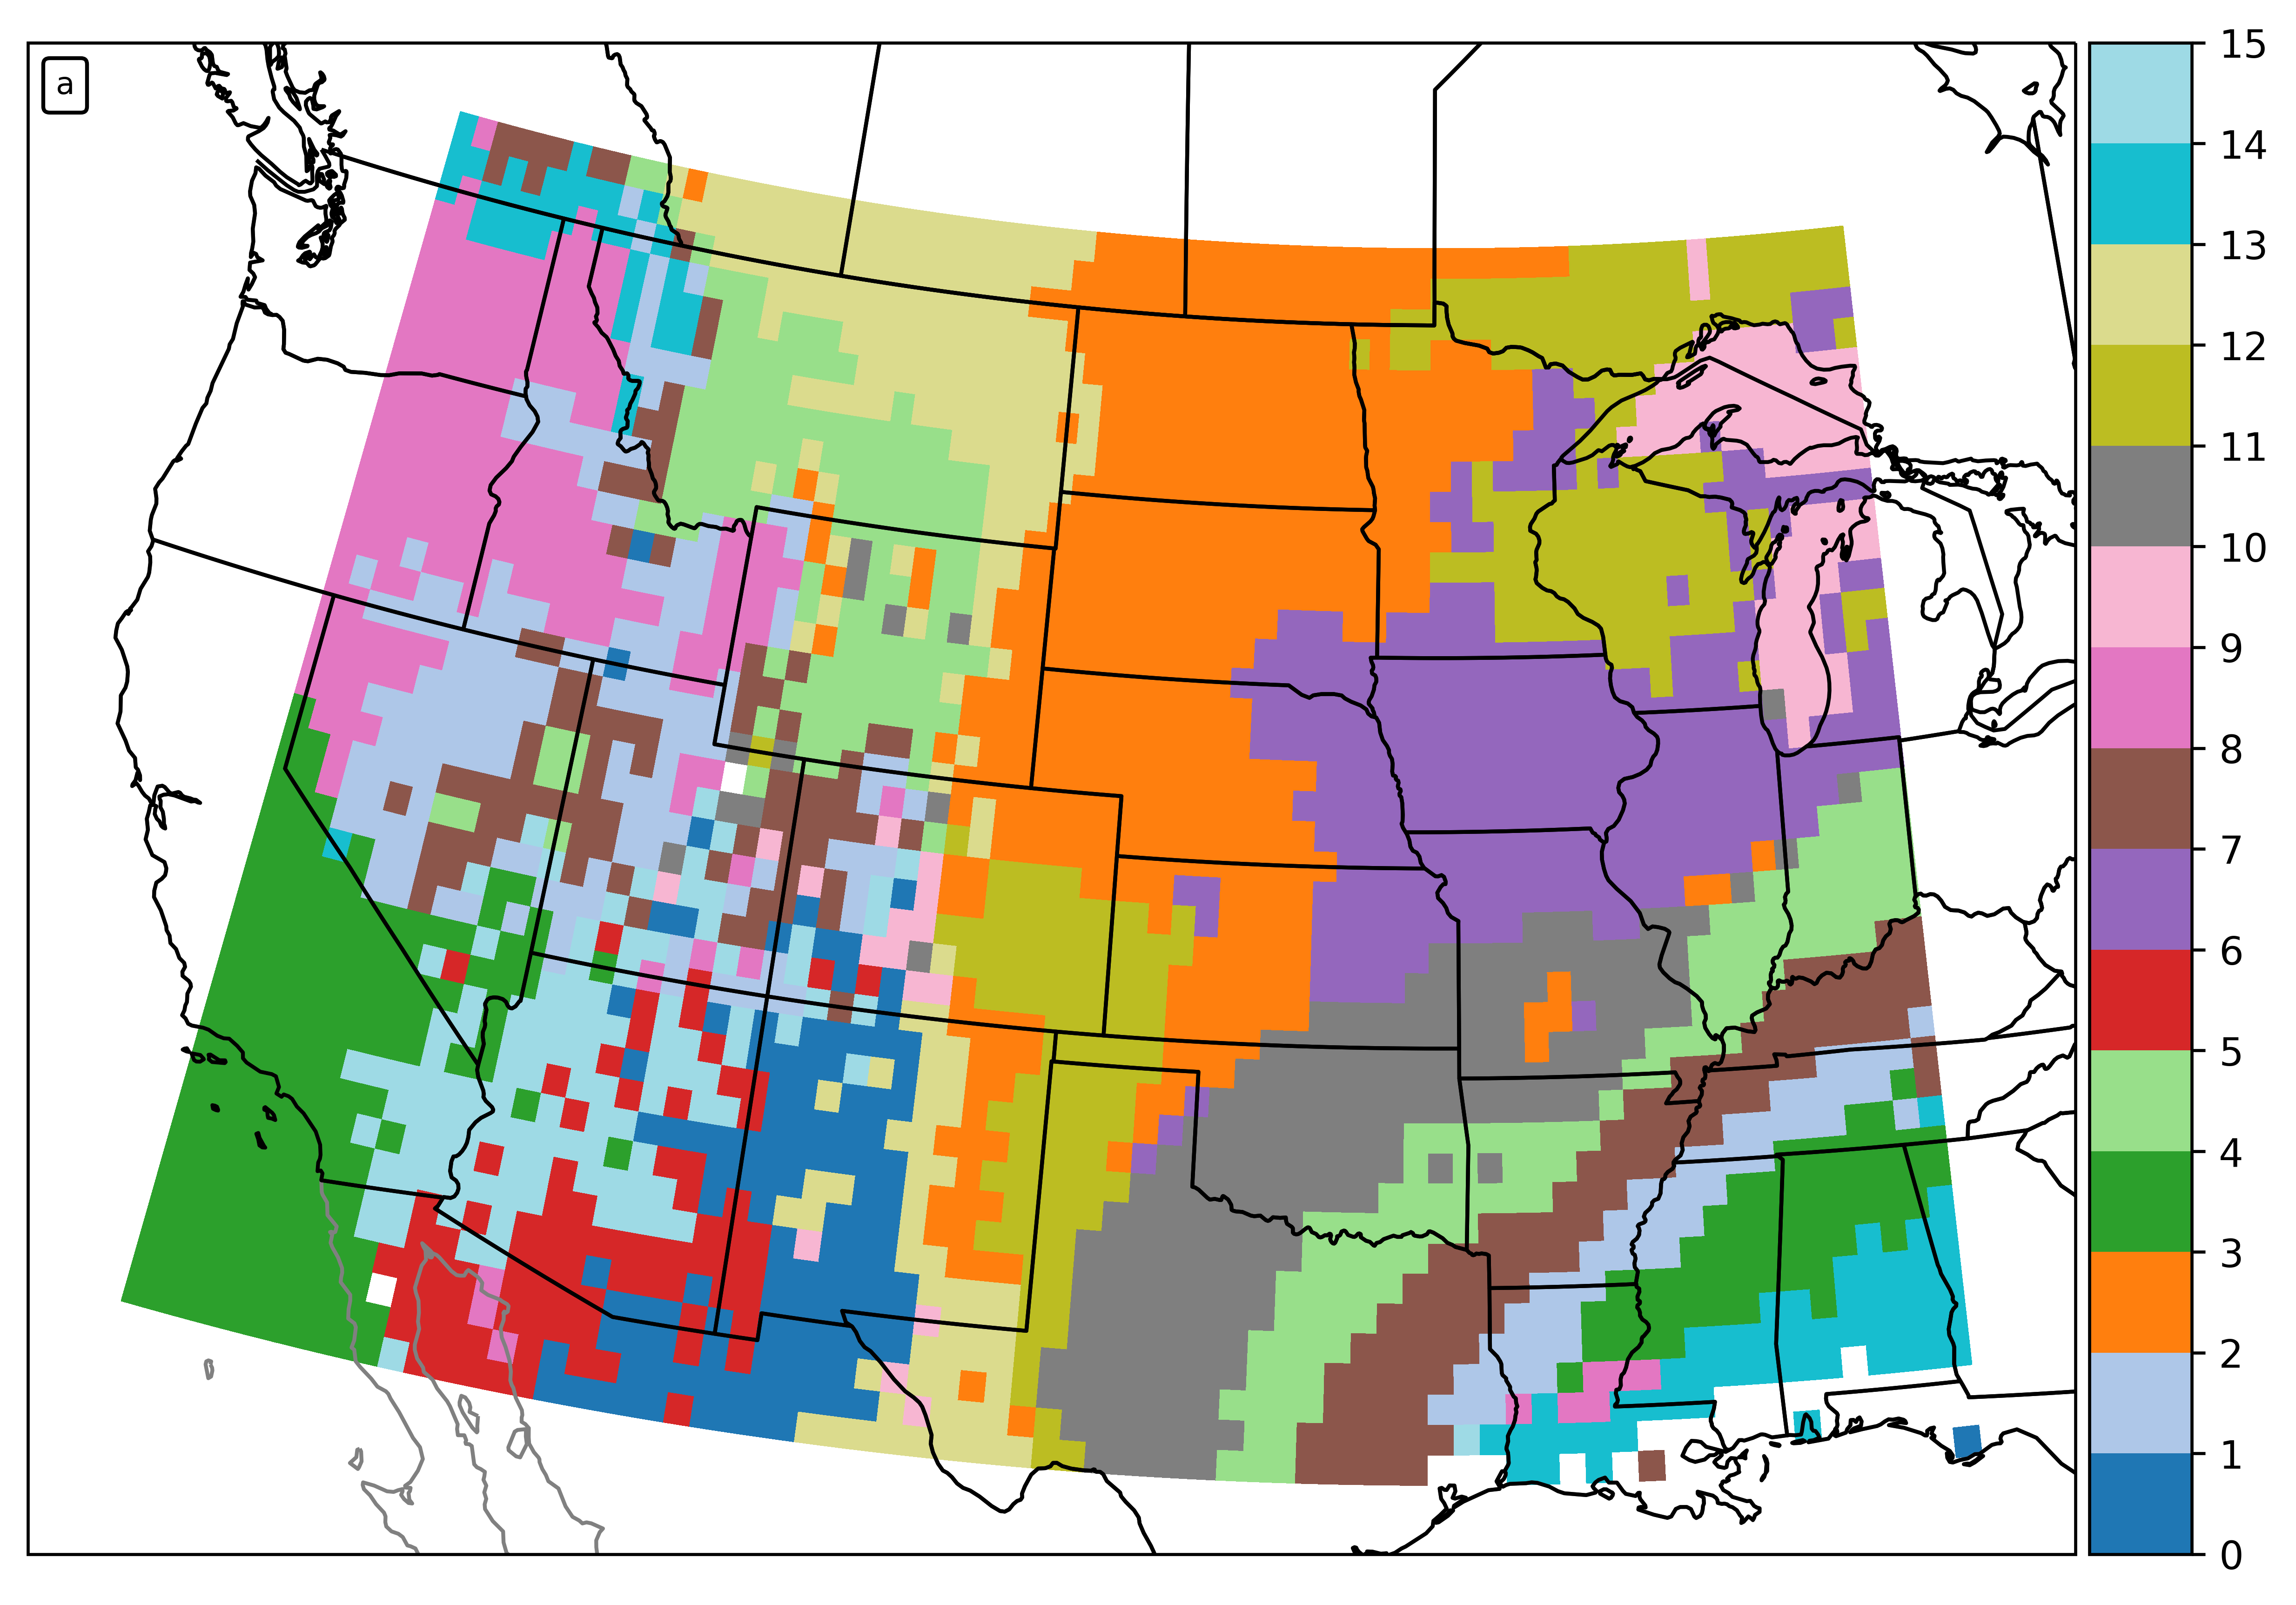

In [57]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
#cmap = mpl.cm.RdBu_r


f, ax1 = plt.subplots(1, 1, figsize=(10, 13), dpi=600, subplot_kw={'projection': map_proj})
p = cluster_ds.plot.pcolormesh(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False, cmap=plt.cm.get_cmap('tab20', 16), levels = np.arange(0,16,1))


### Setting 1st plot parameters ###
ax1.coastlines(color='grey')
ax1.add_feature(cartopy.feature.BORDERS, color='black')
ax1.add_feature(cfeature.STATES, edgecolor='black')
#ax1.set_xticks(np.arange(-180,181, 40))
#ax1.set_yticks(np.arange(-90,91,15))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
at = AnchoredText("a",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
plt.colorbar(p, cax=cax, ticks=np.arange(0,20,1))

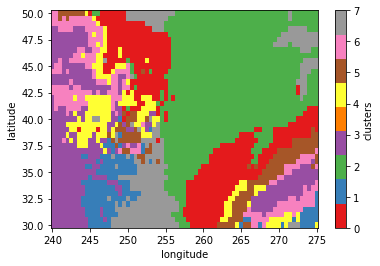

In [25]:
cluster_ds.plot(cmap='Set1')

In [59]:
harmonic_cycle.argmin(dim='dayofyear')

<xarray.DataArray 'precip' (latitude: 41, longitude: 71)>
array([[211, 208, 212, ...,  49,  49,  51],
       [213, 209, 212, ...,  46,  45,  43],
       [272, 208, 210, ...,  46,  42,  34],
       ...,
       [223, 220, 222, ..., 298, 297, 128],
       [220, 223, 224, ..., 126, 301, 307],
       [215, 220, 223, ..., 130, 126, 309]])
Coordinates:
  * longitude  (longitude) float32 240.0 240.5 241.0 241.5 ... 274.0 274.5 275.0
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 31.5 31.0 30.5 30.0

In [28]:
s1 = harmonic_cycle.sel(latitude=33.0, longitude=(260.0)).values

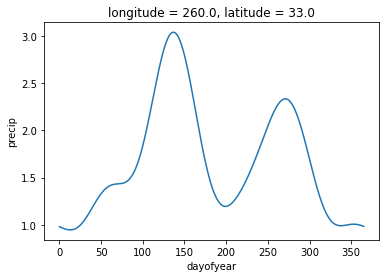

In [27]:
harmonic_cycle.sel(latitude=33.0, longitude=(260.0)).plot()

In [32]:
s2 = harmonic_cycle.sel(latitude=46.0, longitude=(252.0)).values

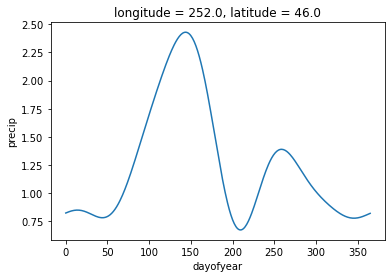

In [29]:
harmonic_cycle.sel(latitude=46.0, longitude=(252.0)).plot()

In [33]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
output = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform([s1])

In [34]:
output2 = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform([s2])

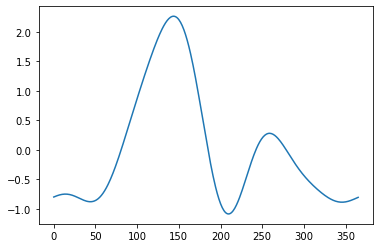

In [35]:
plt.plot(output2.squeeze())

In [195]:
cluster_ds.sel(latitude=35.0, longitude=(261.0))

<xarray.DataArray 'clusters' ()>
array(3)
Coordinates:
    longitude  float32 261.0
    latitude   float32 35.0

In [39]:
from dtaidistance import dtw
distance = dtw.distance(s1, s2)

In [40]:
print(distance)

4.877285418842705


In [24]:
test2 = xr.merge([harmonic_cycle,cluster_ds])

In [40]:
np.unique(cluster_ds.values, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 484,  167, 1002,  429,  181,  146,  217,  285]))

In [128]:
test4 = test2.groupby('clusters').var(dim='dayofyear')

In [151]:
cluster_std = test3.groupby(['clusters','dayofyear']).std()

In [152]:
cluster_std

precip
clusters dayofyear          
0        0          0.240776
         1          0.238387
         2          0.236048
         3          0.233785
         4          0.231619
...                      ...
9        361        0.292662
         362        0.289321
         363        0.285998
         364        0.282701
         365        0.279438

[3660 rows x 1 columns]

In [44]:
cluster2 = test2['precip'].where(test2['clusters']==9).to_dataframe()

distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)


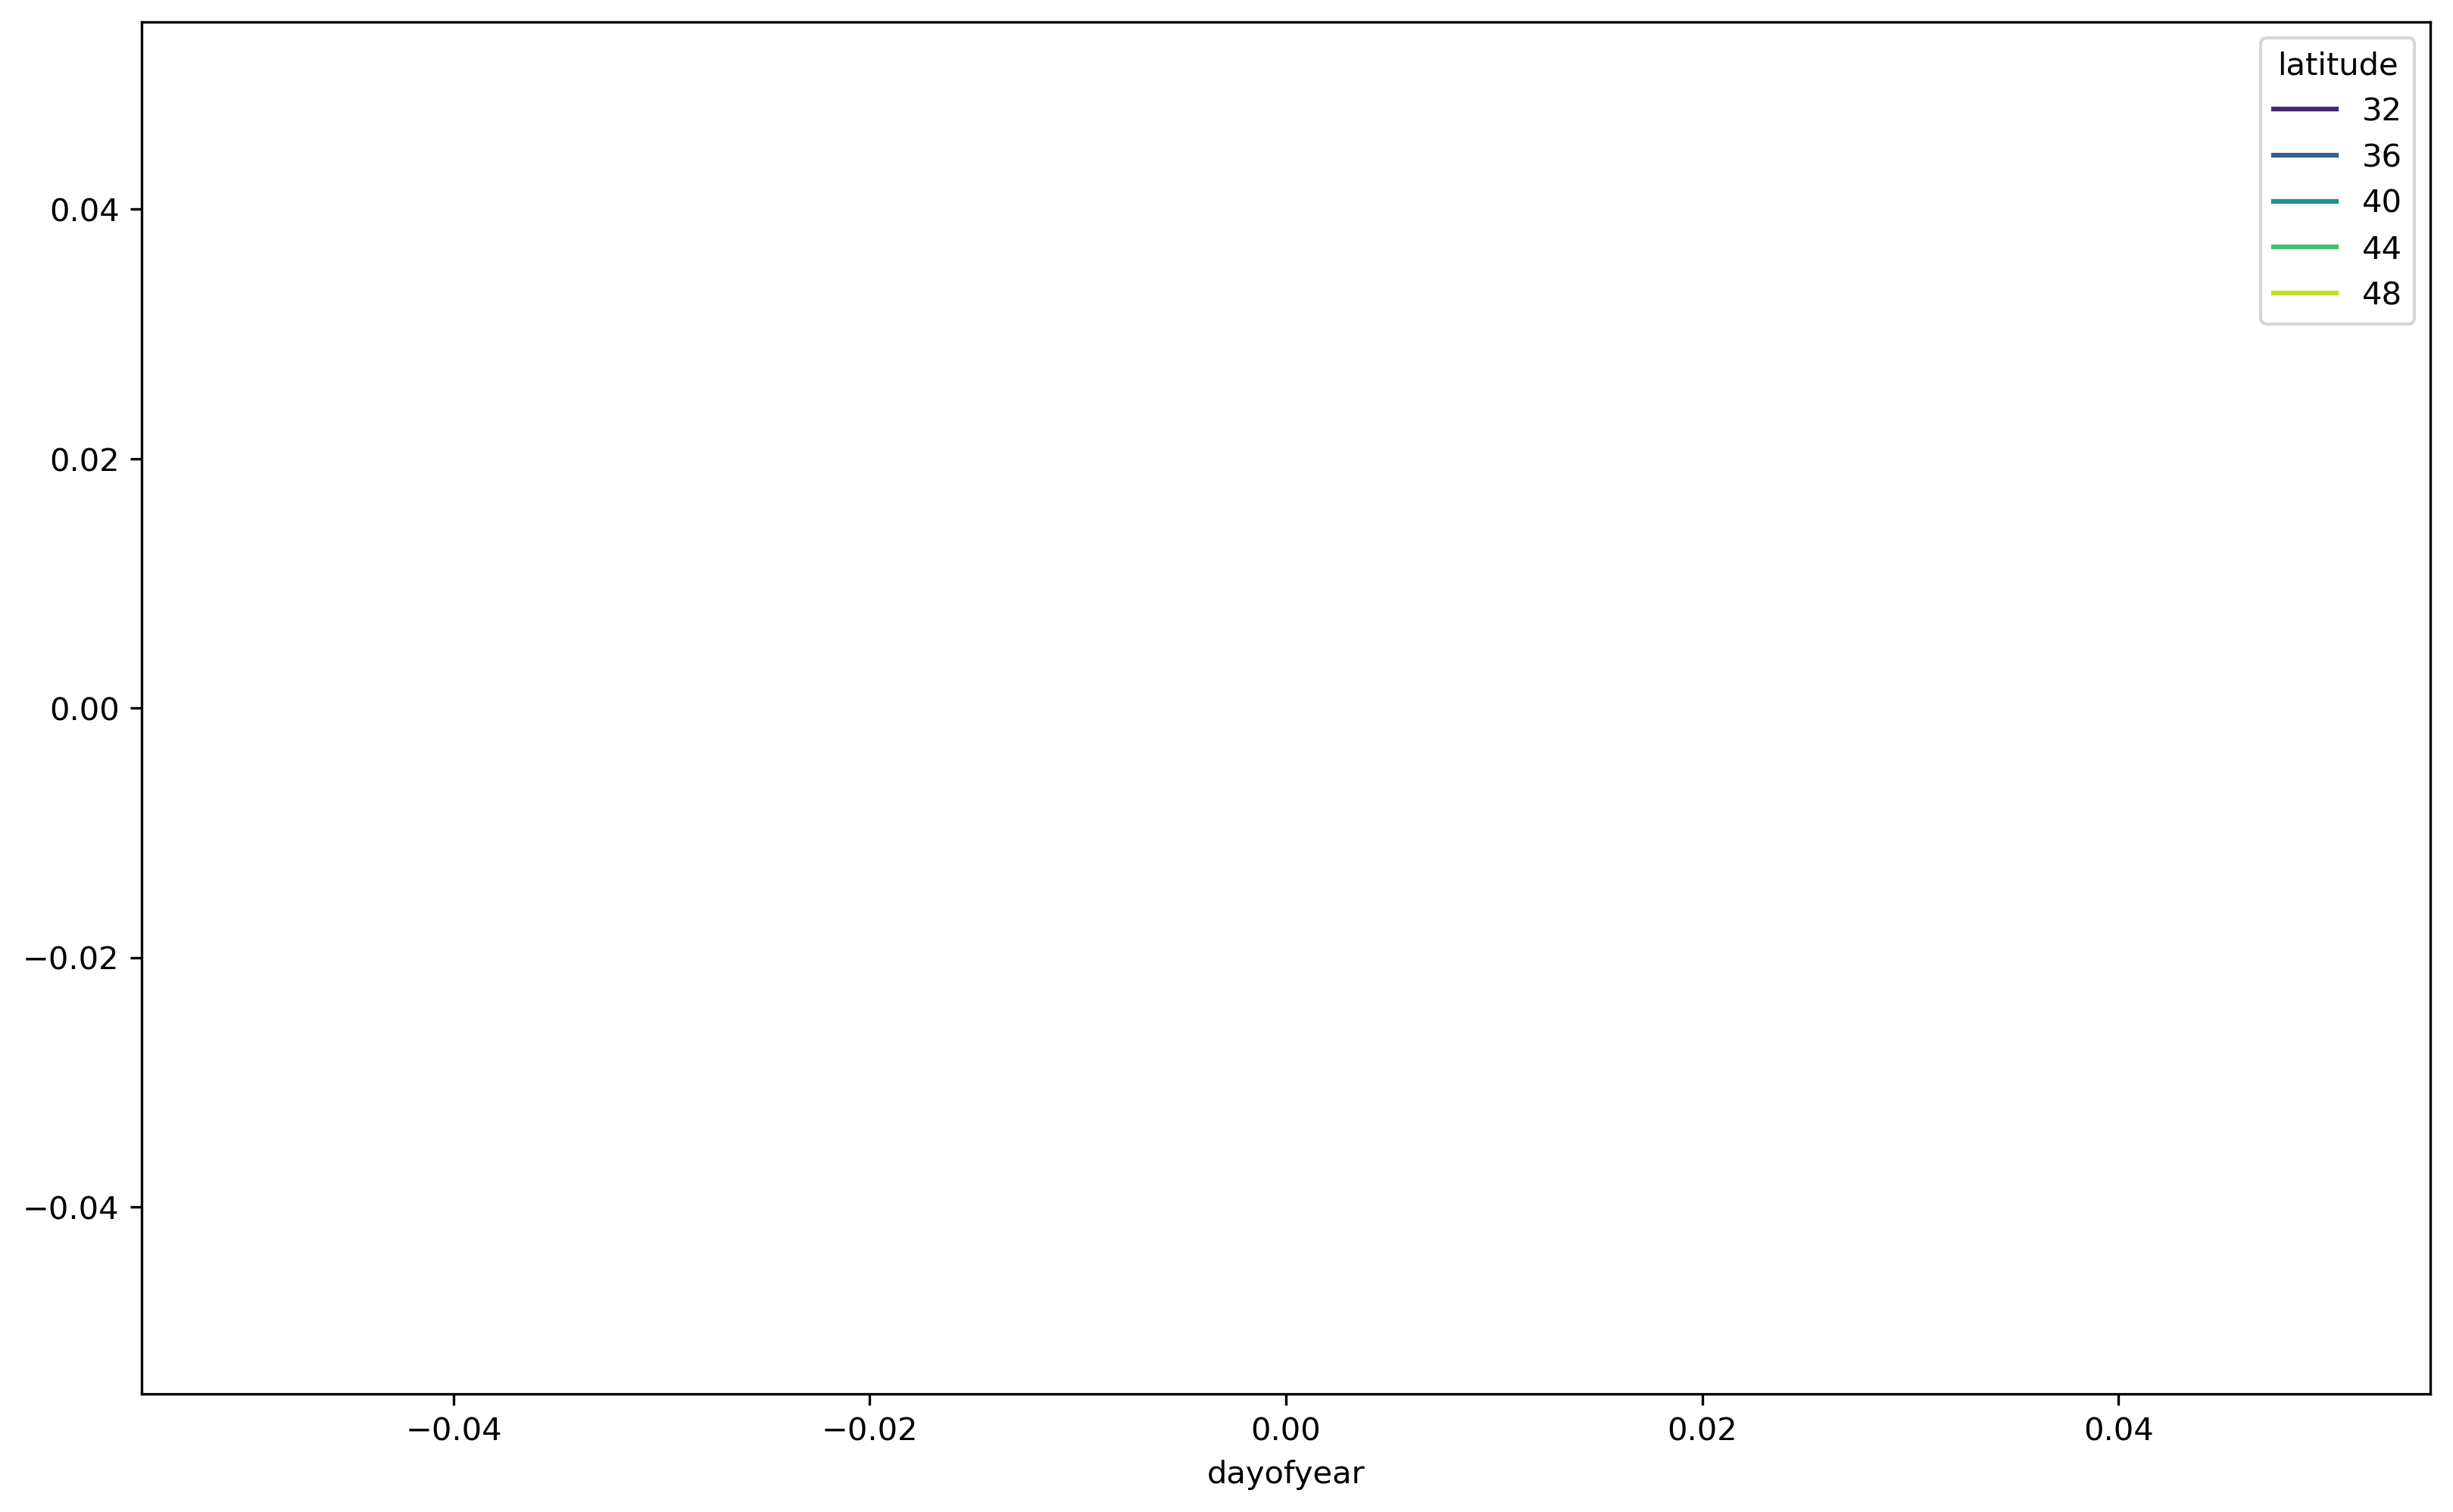

In [45]:
plt.figure(figsize = (13, 8), dpi = 300)

ax = sns.lineplot(data=cluster2, x='dayofyear',y='precip',
                  hue='latitude', palette='viridis',ci=None)

In [42]:
test3 = test2.to_dataframe()

In [42]:
test3

precip  clusters
longitude latitude dayofyear                    
240.0     50.0     0          2.493052         6
                   1          2.483711         6
                   2          2.474213         6
                   3          2.464541         6
                   4          2.454680         6
...                                ...       ...
275.0     30.0     361        3.299204         4
                   362        3.321471         4
                   363        3.342249         4
                   364        3.361492         4
                   365        3.379162         4

[1065426 rows x 2 columns]

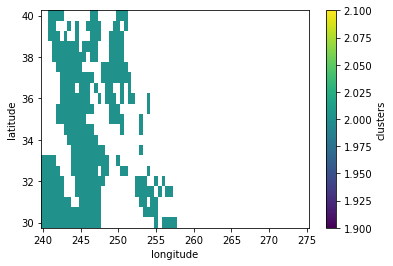

In [115]:
cluster_ds.where(cluster_ds==2).plot()

distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 63% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 63% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 63% CPU time recently (threshold: 10%)


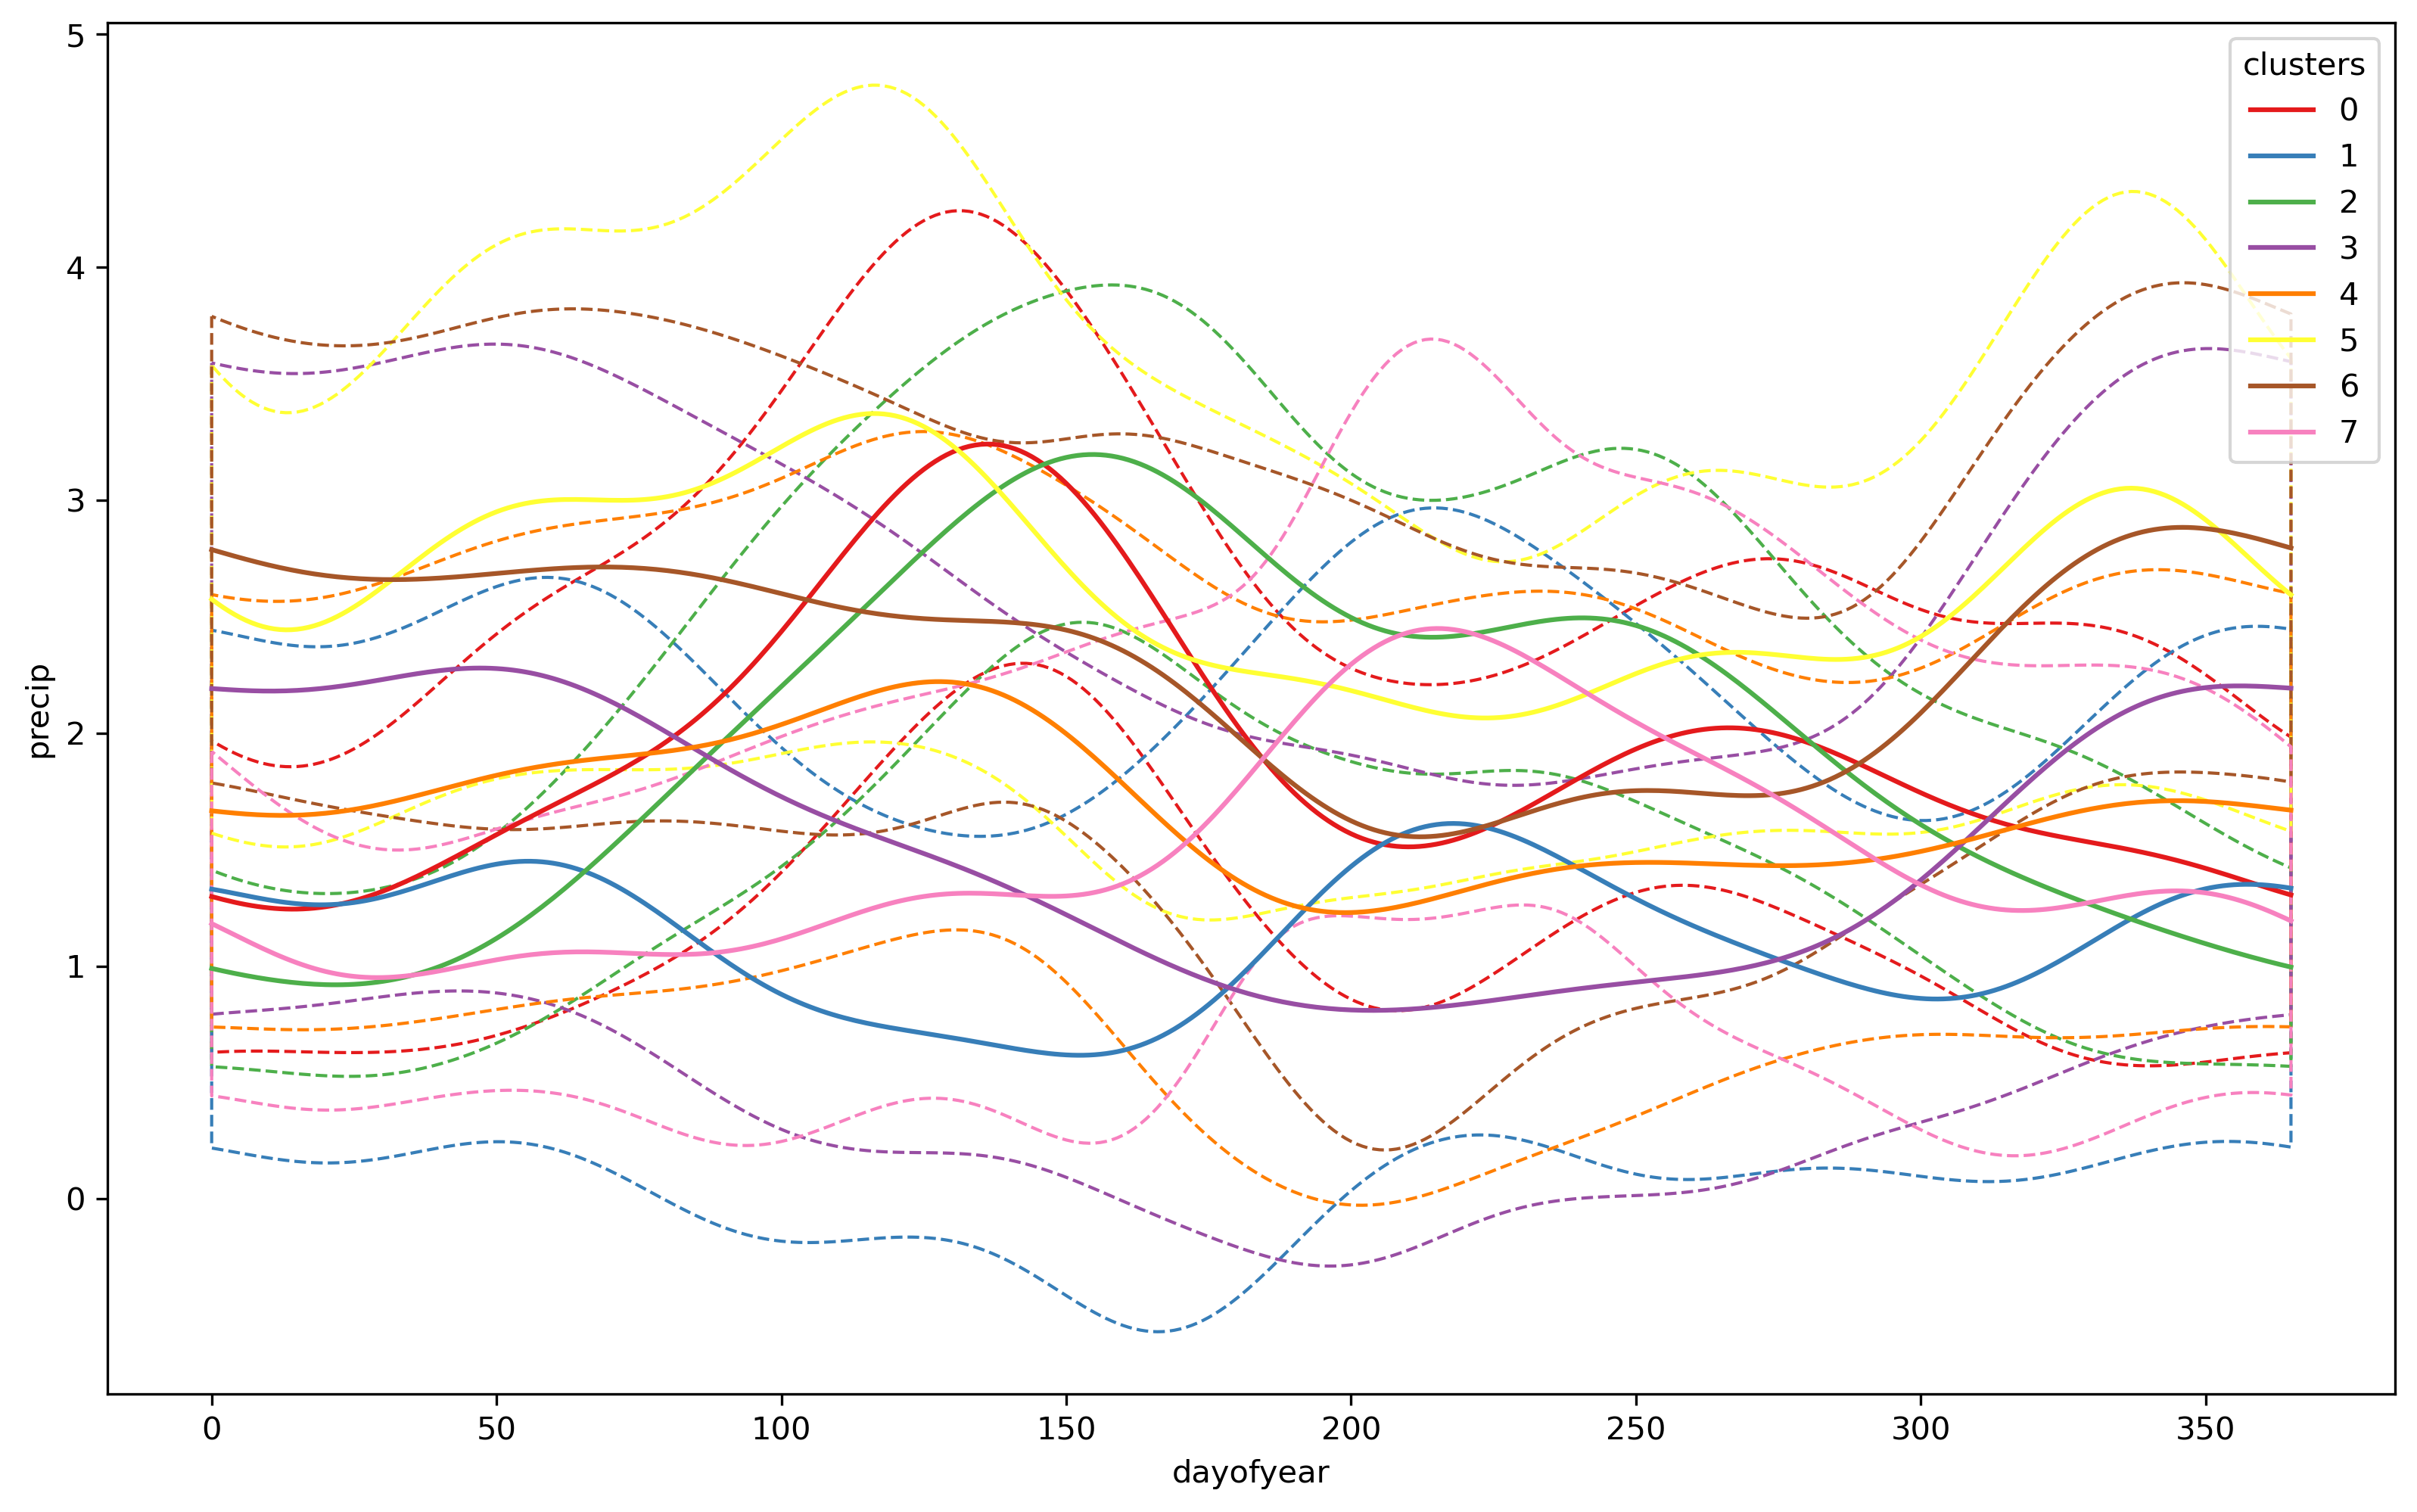

In [54]:
import seaborn as sns
plt.figure(figsize = (13, 8), dpi = 300)

ax = sns.lineplot(data=test3, x='dayofyear',y='precip',
                  hue='clusters', palette='Set1', estimator=np.mean, ci='sd', err_kws={'linestyle':'--','facecolor':'None', 'alpha':1})
#ax.axvline(247, color='g', linestyle='--', lw=2)
#ax.axvline(180, color='r', linestyle='--', lw=2)
#ax.set_ylabel('P anomaly (smoothed)')
#ax.set_xlabel('Day of Year')
#ax.set_title('Desert')


distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 54% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

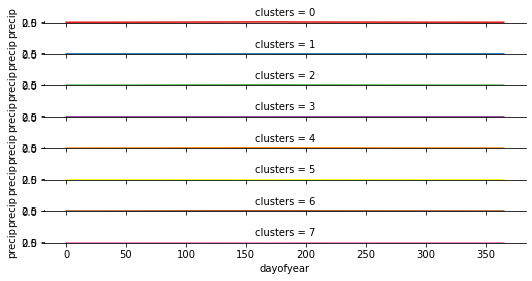

In [48]:
g = sns.FacetGrid(data=test3, row="clusters", hue="clusters", aspect=15, height=.5, palette='Set1')

# Draw the densities in a few steps
g.map(sns.lineplot, data=test3, x="dayofyear",y="precip", ci='sd',estimator=np.median)
#g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
#def label(x, color, label):
#    ax = plt.gca()
#    ax.text(0, .2, label, fontweight="bold", color=color,
#            ha="left", va="center", transform=ax.transAxes)


In [96]:
plotvalues = np.reshape(harmonic_cycle.where(cluster_ds==5).values,(21*71,366))

In [100]:
plotvalues

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [121]:
lat = 30.0
lon = 246.0

In [122]:
cluster_ds.sel(latitude=lat,longitude=lon)

<xarray.DataArray 'clusters' ()>
array(2)
Coordinates:
    longitude  float32 246.0
    latitude   float32 30.0

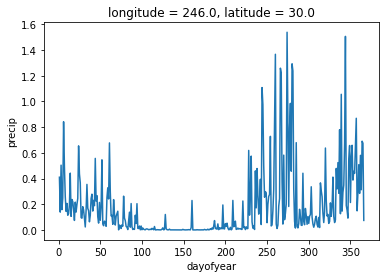

In [123]:
annual_precip_cycle.sel(latitude=lat, longitude=lon).plot()